# COSC 426 / 526 - Assignment 06
### Discussed: Feb 28, 2025
### Due: March 7, 2025
---

*Note: Running a cell will not rerun previous cells.  If you edit code in previous cells, you must rerun those cells.  We recommend using* `Run All` *to avoid any errors results from not rerunning previous cells.  You can find this in the menu above:* `Cell -> Run All`

During the last lecture, we learned about the **Apache Spark** implementation of the **MapReduce** programming model.  In this assignment, we will use **PySpark** (the Spark Python API) to perform one of the text parsing problems that we solved in the last assignment *with the power of parallel processing*. In the previous assignment, we defined three sequential methods (i.e., `mapSequential`, `reduceSequential`, and `reduceByKeySequential`) that extend Python's `map` and `reduce` functions.  In this assignment, we will be using PySpark's parallel version of these functions.

### Testing PySpark
Run the cell below to verify that your Java, Spark, and PySpark installations are successful. The cell generates a dataset of numbers (i.e., 1, 2, 3, 4, 5, 6, 7, 8, 9, and 10) and computes their sum. The expected output is 45.

In [12]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
data = sc.parallelize(range(1,10))
print(data.reduce(lambda x,y: x+y))
sc.stop()

45


### Problem 0:
Now that we are in Jetstream, open your completed Assignment05 and rerun it. Executing the same code on different machines is a valuable test of the portability of your code.

### Problem 1:

Now that we have Spark installed and running in our Jupyter Notebook environment, we can move from *sequential* text processing in Python (i.e., Assignments 4 and 5) to the *parallel* implementation in *Apache Spark*.  **In this assignment we will redo the problems from Assignment05 using Apache Spark.**  *Note that the code you wrote for the sequential version should work with the parallel version.  You will only need to adapt to using Spark's parallelized data structure, the `RDD`.* 

Below, we provide the functions implemented in the Assignment04 (e.g., the building blocks of analyses provided by domain scientists, that you are asked to parallelize).  Notice the one minor change from the previous assignment: the `preprocessLine` function is similar to `loadText` but it is designed to operate on a single line as opposed to an entire file.  This allows the pre-processing to occur on each line in the file in parallel.

In [13]:
# Define a method for reading and processing individual lines of a text file
# Like `loadText` in assignment 5 except that it operates on a single line, rather than an entire file
def preprocessLine(line):
    import re
    
    # Remove all non-alphabet characters with a regular expression
    text_alpha = re.sub(r'[^a-zA-Z]', ' ', line)

    # Convert characters to upper-case
    text_upper = text_alpha.upper()
    
    # Convert the string of text into a list of words and remove empty words
    words = [w for w in text_upper.split(' ') if w is not '']
    
    return words

# Return the length of a given word
def wordLength(word):
    return len(word)

# Given a key and value, return a (key, value) pair
def makeKeyValue(key, value=1):
    return (key, value)

# Count (reduce) the values for a given key (word length)
def addValues(val1, val2):
    return val1 + val2

# Given a word, return an iterable of characters
def splitWord(word):
    return list(word)

# Define a method to return position of each character
def lettersPosition(word):
    import numpy as np

    if len(word) == 1:
        # Base case for words of length 1
        return [(word, np.array([1,0,0]))]
    else:
        # Get first and last letters
        first, last = word[0], word[-1]
        pos_list = [(first, np.array([1,0,0])), (last, np.array([0,0,1]))]

        # Get interior letters
        interior = word[1:-1]
        for char in interior:
            pos_list.append((char, np.array([0,1,0])))

    return pos_list

<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_33740/3558869969.py:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  words = [w for w in text_upper.split(' ') if w is not '']


Create a Spark Context and use the new preProcessLine function to import the text from The Count of Monty.

In [14]:
# Create the Spark Context (sc)
sc = SparkContext.getOrCreate()

# Create the RDD containing the text from the Count of Monte Cristo
# HINT: ref 1
file_path = "Book_CountOfMonteCristo.txt"
data = sc.textFile(file_path)

# Pre-process the lines in the RDD
# (i.e., remove special characters, make uppercase, split into words)
# What kind of Spark map function do you need in this situation?
# Think about the structure of what is returned by each call to the map fuction,
# and about what you want the final structure to be
# HINT: ref 2 or 3
words = data.flatMap(preprocessLine)

Analyze the text for word length frequency. We might expect short words to be more common than long words. But, are words of length 2 more common than words or length 3? Are words of length 3 more common that words of length 4? **Use the pre-processed text, `words`, from the previous cell to count the frequency of each word length in the text using the parallel MapReduce methods of Spark.**

In [15]:
# Map the length of each word, using the wordLength function defined above
# HINT: ref 3
word_lengths = words.map(lambda word: wordLength(word))
    
# Map keyvalue pairs to help count each word length, using the makeKeyValue function defined above
word_keyvalues = word_lengths.map(lambda length: makeKeyValue(length))
    
# ReduceByKey to count number of words with each length, using the addValues function defined above
# HINT: ref 4
word_length_counts = word_keyvalues.reduceByKey(addValues)

# Extract the six most common word-lengths from the RDD
# HINT: ref 5
wl_counts_sorted_six = word_length_counts.sortBy(lambda pair: pair[1], ascending=False).take(6)

# Print the 6 most common word lengths
print('Word Length : Count')
for word_len, count in wl_counts_sorted_six:
    print('{:<11d} : {:>6d}'.format(word_len, count))

Word Length : Count
3           : 109798
2           :  84021
4           :  81777
5           :  49101
6           :  39015
7           :  30701


#### Expected Output:
```
Word Length : Count
3           : 109798
2           :  84021
4           :  81777
5           :  49101
6           :  39015
7           :  30701
```
#### References
- [1: textFile](http://spark.apache.org/docs/latest/api/python/reference/api/pyspark.SparkContext.textFile.html#pyspark.SparkContext.textFile)
- [2: flatMap](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.flatMap.html#pyspark.RDD.flatMap)
- [3: map](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.map.html#pyspark.RDD.map)
- [4: reduceByKey](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.reduceByKey.html#pyspark.RDD.reduceByKey)
- [5: top](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.top.html#pyspark.RDD.top)

### Problem 2:
Analyze the text for letter frequency. If you’ve taken a crypto course and/or have seen substitution ciphers then you are probably aware that ’e’ is the most common letter used in the English language.  **Use the pre-processed text `words` to count the frequency of each letter in the text using the parallel MapReduce methods of Spark**.

In [16]:
# The next two calls require you to use the map function
# Think about which map (i.e., flatMap or Map) is most suitable

# Map list of words to list characters, using the splitWord function defined above
chars = words.flatMap(splitWord)

# Map list of characters to list of key-value pairs, using the makeKeyValue function defined above
char_keyvalues = chars.map(lambda char: makeKeyValue(char))

# ReduceByKey to count number of occurrences of each letter
char_counts = char_keyvalues.reduceByKey(addValues)

# Extract the 6 most common characters from the RDD
top_six_chars = char_counts.sortBy(lambda x: x[1], ascending=False).take(6)

# Print the 6 most common characters
print("{:<11} : {:<6}".format("Character", "Count"))
for char, count in top_six_chars:
    print("{:<11} : {:<6}".format(char, count))

Character   : Count 
E           : 258693
T           : 180211
A           : 165306
O           : 156817
I           : 142095
N           : 137343


#### Expected Output:
```
Character : Count
E         : 258693
T         : 180211
A         : 165306
O         : 156817
I         : 142095
N         : 137343
```

### Problem 3:
If we really wanted to crack a substitution cipher (or win on "Wheel of Fortune") then we should be aware that, although 'e' is the most common letter used in English, it may not be the most common first letter in a word. **Count the positional frequencies of each letter using the parallel MapReduce methods of Spark. Specifically, count the number of times each letter appears as the first letter in a word, as the last letter in a word, and as an interior letter in a word (i.e. a letter that is neither first nor last)**. 

In [17]:
import numpy as np

# Map the location of each character within the words
char_positions = words.flatMap(lettersPosition)

# Reduce the letter positions for each character
char_position_counts = char_positions.reduceByKey(lambda char_positions, addValues: np.add(char_positions, addValues))

# Collect the counts for the first 6 characters in the alphabet (i.e., A-F)
# HINT: ref 1
cp_sorted_six = sorted(char_position_counts.filter(lambda x: x[0] in {'A', 'B', 'C', 'D', 'E', 'F'}).collect())

# Print the position frequency of the first letters in the alphabet
print('Character : First | Interior |  Last')
for char, char_position in cp_sorted_six:
    first, interior, last = char_position
    print('{:<9} : {:5d} | {:>8d} | {:>5d}'.format(char, first, interior, last))

Character : First | Interior |  Last
A         : 51644 |   111686 |  1976
B         : 18866 |     8516 |   541
C         : 19577 |    32130 |   725
D         : 17289 |    18613 | 58075
E         : 10178 |   153205 | 95310
F         : 17724 |    10618 | 16988


#### Expected Output:
```
Character : First | Interior |  Last
A         : 51644 |   111686 |  1976
B         : 18866 |     8516 |   541
C         : 19577 |    32130 |   725
D         : 17289 |    18613 | 58075
E         : 10178 |   153205 | 95310
F         : 17724 |    10618 | 16988
```
#### References
- [1: takeOrdered](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.takeOrdered.html#pyspark.RDD.takeOrdered)

### Problem 4:
As you did in Problem 4 of Assignment04, use matplotlib to create histograms for Problems 1-3.

In [18]:
# Import matplotlib's pyplot
from matplotlib import pyplot as plt

Plot word_length_counts from Problem 1, ordered by word length.

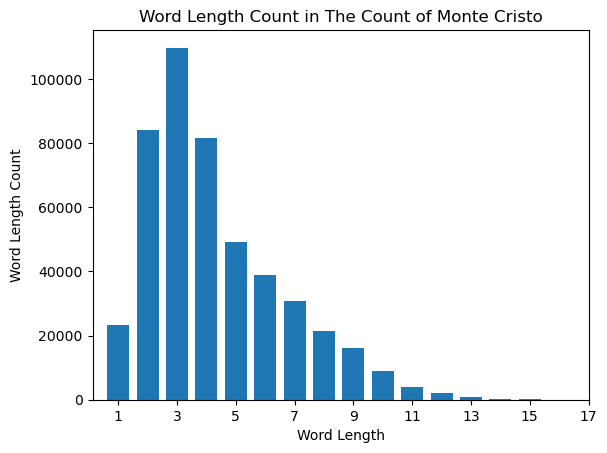

In [19]:
# Collect the data from the RDD into a list
# HINT: ref[1]
word_length_counts_list = word_length_counts.collect()

# Sort word length list by length of word
word_length_counts_sorted = sorted(word_length_counts_list, key=lambda x: x[0])

# Get X and Y values
X_vals, Y_vals = zip(*word_length_counts_sorted)

# Plot the histogram
plt.bar(X_vals, Y_vals, 0.75)
plt.xlim((.125, len(X_vals)))
plt.xticks(range(1,len(X_vals)+1,2))
plt.xlabel('Word Length')
plt.ylabel('Word Length Count')
plt.title('Word Length Count in The Count of Monte Cristo')
plt.show()

Plot char_counts from Problem 2, ordered alphabetically.

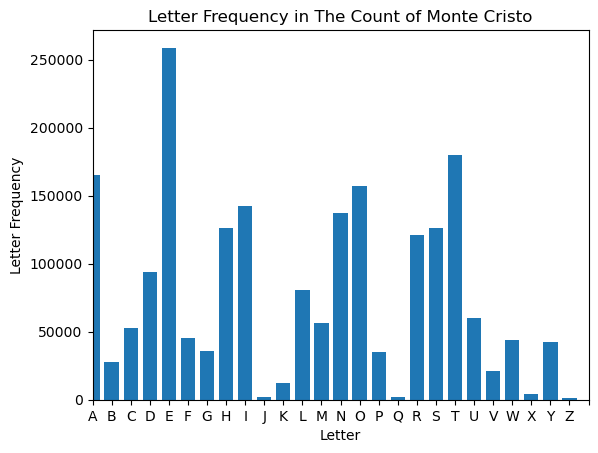

In [20]:
# Make sure you clear (i.e., delete) previous figures with this
plt.clf()

# Collect the data from the RDD into a list
char_counts_list = char_counts.collect()

# Sort character count list alphabetically
char_counts_sorted = sorted(char_counts_list, key=lambda x: x[0])

# Use the sorted list of tuples contain characters and character counts to get X and Y values
X_vals, Y_vals = zip(*char_counts_sorted)

# Plot the histogram
plt.bar(X_vals, Y_vals, 0.75)
plt.xlim((.125, len(X_vals)))
plt.xticks(range(0,len(X_vals)+1,1))
plt.xlabel('Letter')
plt.ylabel('Letter Frequency')
plt.title('Letter Frequency in The Count of Monte Cristo')
plt.show()

Plot char_position_counts from Problem 3, ordered alphabetically with three bars per letter.

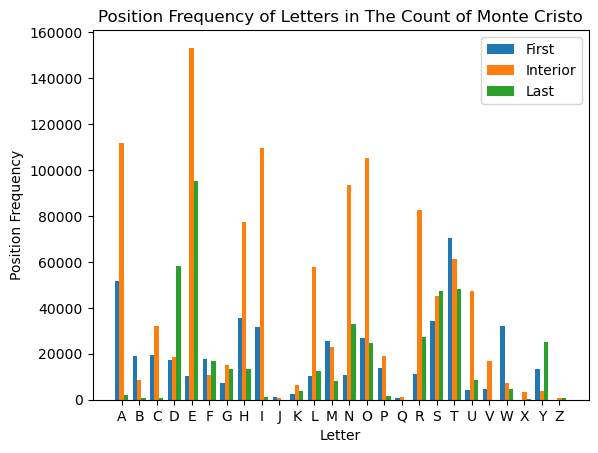

In [21]:
# Clear previous figure
plt.clf()

# Collect the data from the RDD into a list
char_position_counts_list = char_position_counts.collect()

# Sort the list of character position count values alphabetically
char_position_counts_sorted = sorted(char_position_counts_list, key=lambda x: x[0])

# Get a list of X values and 3 lists for Y values (first, interior, and last)
X_vals, Y_vals = zip(*char_position_counts_sorted)
first = [Y_vals[i][0] for i in range(len(Y_vals))]
interior = [Y_vals[i][1] for i in range(len(Y_vals))]
last = [Y_vals[i][2] for i in range(len(Y_vals))]

# Set proper X_pos values for each list of values (first, interior, last)
x = np.array(range(len(X_vals)))
width = 0.25 
plt.bar(x - width, first, width=width, label='First')
plt.bar(x, interior, width=width, label='Interior')
plt.bar(x + width, last, width=width, label='Last')
plt.xticks(x, X_vals)

# Plot the histograms
plt.xlabel('Letter')
plt.ylabel('Position Frequency')
plt.title('Position Frequency of Letters in The Count of Monte Cristo')
plt.legend()
plt.show()


#### References
- [1: collect](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.collect.html#pyspark.RDD.collect)

In [22]:
# Stop the Spark Context
sc.stop()

### Things to Consider:
* You used the collect() function for Problem 4 to move the data from RDDs to lists. This collects the distributed data, which is okay for the small datasets used presently, but would be unwise if you are using Spark to handle very large datasets.
* Parallel computation can save time by completing multiple pieces of work simultaneously on different processors. However, if you were to track the execution time for Problems 1-3 above and compare it with Assignment05, Assignment06 could very well be slower. Why?

Parallel computation would work well for a large dataset because you are breaking the amount of work and distributing it to different processors. For Assignment05 and Assignment06, the RDD and tasks are small, so it ends up taking more resources and computation time to distribute, schedule, and synchronize than computing the end product.

## Problem 5. Write the comprehensive README files for the assignment

**Note:** These directions are for a README file for your assignments. An more extensive README file should be used for your project. 

***Write the comprehensive README files for this assignment***

A comprehensive README file on GitHub is the primary information source for anyone exploring your repository. It is essential for clearly conveying your assignment's purpose, setup, and usage.

Key elements of a comprehensive README for an assignment include:

Assignment title: This should clearly state the name of your project.

Assignment description: Provide a concise overview of what the project entails. This section should explain the project's usefulness and the problems it addresses.

Installation instructions: Offer detailed steps for setting up the project. This includes any prerequisites, dependencies, and a step-by-step guide to operationalizing the project.

Use: Give clear instructions on how to use the project. Enhance this section with practical examples, including code snippets, screenshots, or videos.

Contact information: Detail how to contact you. This could be through email.

Acknowledgments: Credit any individuals, organizations, or other entities contributing significantly to the assignment.

**Add the README file to the GitHub repository with the solution of this assigment.**

### Problem 6: Project

**Find an interesting dataset.**

Now that you've heard a bit about the projects we will be doing later in this class find a dataset that you *could* use for the project. It should be large enough to allow for interesting analysis and non-trivial results. You don't have to download the data; make sure you do NOT add it to your GitHub repository.

In the box below, describe the dataset you have selected in one or two paragraphs. Include its source (with URL). Other information you may include is how the data were collected; the significance of the data; the number of rows, objects, or data points; what information is contained in each; data types (int, str, char, float, etc.) and numerical ranges where appropriate; and any details about the file that would be necessary for loading the data into a program.

**NOTE: This is an exercise in finding and describing data for research.**

### Agency for Healthcare Research and Quality's Social Determinants of Health Database
The Agency for Healthcare Research and Quality (AHRQ) is a government agency that supports research to "improve the quality, safety, efficiency, and effectiveness of health care for all Americans" [1]. The database project's purpose is to "create easy to use, easily linkable SDOH-focused data to use in PCOR research, inform approaches to address emerging health issues, and ultimately contribute to improved health outcomes" [4]. The data was curated from existing Federal datasets and other public data sources. Social determinants include those in the social domain (age, race, etc.), economic domain (income, employment, etc.), education, physical infrastructure, and healthcare. The data can be sorted by county, zip code, and census tract from years 2009 to 2020, but I will be focusing on the 2020 census tract version. 

There are a total of 329 variables and 85528 rows in the dataset. The two data types are integers and strings. There are general variables such the year, census tract FIPS code, and state name. The majority of the variables are specific labels such as "Percentage of owner-occupied housing units with selected monthly owner costs equal to 30 percent or more of household income" or "Total population (ages 25 and over)." Since the labels can be lengthy, the data columns are shortened codes like "YEAR" or "ACS_TOT_POP_WT." When loading in the Microsoft Excel spreadsheet (.xlsx), it will be important to include the "Layout" sheet in addition to the "Data" sheet because the "Layout" sheet contains all the labels for the column names.

The link to the data is https://www.ahrq.gov/sdoh/data-analytics/sdoh-data.html. Again, I will be using the Census Tract Data 2020 version. 


### Addition: U.S. 2020 Census Tract Shapefiles
Since the AHRQ data I'm choosing is using the census tract, I will also be using the official United States Census Bureau 2020 census tract shapefiles. The shapefiles include the census tract FIPS code and the Shapely polygon geometry data to plot them. This way I can plot the different variables from the AHRQ dataset to form a map of the United States. There seem to be multiple tracts and zip files, so I'll have to do some investigation on the shapefiles and try combining them all together before I can join them with the AHRQ data.

The general link to the US Census Bureau shapefiles is https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html. The specific 2020 US census tract can be found https://www2.census.gov/geo/tiger/TIGER2020/TRACT/. 

### Live Chat:
 Hans Rosling's best stats you've ever seen

Hans Rosling was well-known for his effective ways to present (visualize) data.

This video shows effective ways to present data that evolves in space (geographically) and time (across yeas)
“ The best stats you've ever seen - Hans Rosling” https://youtu.be/usdJgEwMinM

Can you list and briefly discuss one aspect you learned from the video about the data visualization? (max 200 words)

Hans Rosling's visualization is actually now called the Bubbles visualization from Gapminder. In his presentation, he demonstrated the purpose of data visualization by plotting the life expectancy and GDP of countries over centuries using his design tool GapMinder. There's lots data that is not being used properly because of how much effort it takes to obtain the data and scrub through spreadsheets. Data points by themselves are not enough to spur lawmakers and the public into action. But with design tools and data visualization, the important takeaways, such as what different countries' economic standings say about their healthcare, are clear and digestible. The impact of making those facts clearer can be, in Rosling's visualization's case, tackling preconceived notions and contextualizing the improvement of the world.